Pada latihan kali ini, kita akan menggunakan data 'credit_scoring'

# Data Loading

# Membaca Data dan menampilkan data

In [53]:
# import library yang dibutuhkan disini
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#library untuk menilai akurasi dari model
from sklearn.metrics import accuracy_score

# library evaluasi model confusion matrix
from sklearn.metrics import confusion_matrix

#library algoritma
from sklearn.naive_bayes import GaussianNB

In [54]:
dataset_credit_scoring = pd.read_excel('data.xlsx')
dataset_credit_scoring.head()

,kode_kontrak,pendapatan_setahun_juta,kpr_aktif,durasi_pinjaman_bulan,jumlah_tanggungan,rata_rata_overdue,risk_rating
0,AGR-000001,295,YA,48,5,61 - 90 days,4
1,AGR-000011,271,YA,36,5,61 - 90 days,4
2,AGR-000030,159,TIDAK,12,0,0 - 30 days,1
3,AGR-000043,210,YA,12,3,46 - 60 days,3
4,AGR-000049,165,TIDAK,36,0,31 - 45 days,2


pandas adalah library yang digunakan untuk melakukan manipulasi data. Disini, pandas digunakan untuk membaca data.

karena data yang digunakan adalah format excel dengan ekstensi xlsx, maka digunakan read_excel.

setelah data di load. tampilkan 5 baris data pertama dengan menggunakan fungsi head.

# Data Preparation

sebelum data benar benar dilatih, ada tahap dimana data tersebut dipersiapkan dulu. Pada tahap ini berkaitan dengan EDA (Exploratory Data Analysisi) pada tahap ini, biasanya digunakan untuk memastikan bahwa data yang ingin dilatih telah sesuai dan tidak lagi cacat.

In [55]:
dataset = dataset_credit_scoring[['pendapatan_setahun_juta', 'kpr_aktif', 'durasi_pinjaman_bulan', 'jumlah_tanggungan', 'rata_rata_overdue', 'risk_rating']]
dataset.head()

,pendapatan_setahun_juta,kpr_aktif,durasi_pinjaman_bulan,jumlah_tanggungan,rata_rata_overdue,risk_rating
0,295,YA,48,5,61 - 90 days,4
1,271,YA,36,5,61 - 90 days,4
2,159,TIDAK,12,0,0 - 30 days,1
3,210,YA,12,3,46 - 60 days,3
4,165,TIDAK,36,0,31 - 45 days,2


ML hanya dapat dilakukan pada data berupa **NUMERIK**, maka data pada **kpr_aktif** dan **rata_rata_overdue** harus diubah ke bentuk numerik

In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   pendapatan_setahun_juta  900 non-null    int64 
 1   kpr_aktif                900 non-null    object
 2   durasi_pinjaman_bulan    900 non-null    int64 
 3   jumlah_tanggungan        900 non-null    int64 
 4   rata_rata_overdue        900 non-null    object
 5   risk_rating              900 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 42.3+ KB


jika dilihat pada tabel info, kpr_aktif dan rata_rata_overdue memiliki Dtype object, dimana object merupakan tipe data bukan angka. Sehingga ML tidak akan dapat mengolah angka tersebut

In [57]:
# mengubah data kpr_aktif menjadi tipe integer : dimana 'YA' menjadi 1 dan 'TIDAK' menjadi 0
dataset['kpr_aktif'] = dataset['kpr_aktif'].replace(['YA', 'TIDAK'], [1, 0])
print("dataset mengubah kpr_aktif menjadi numerik")
dataset.head()

dataset mengubah kpr_aktif menjadi numerik


/tmp/ipython-input-2272350994.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['kpr_aktif'] = dataset['kpr_aktif'].replace(['YA', 'TIDAK'], [1, 0])
/tmp/ipython-input-2272350994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['kpr_aktif'] = dataset['kpr_aktif'].replace(['YA', 'TIDAK'], [1, 0])


,pendapatan_setahun_juta,kpr_aktif,durasi_pinjaman_bulan,jumlah_tanggungan,rata_rata_overdue,risk_rating
0,295,1,48,5,61 - 90 days,4
1,271,1,36,5,61 - 90 days,4
2,159,0,12,0,0 - 30 days,1
3,210,1,12,3,46 - 60 days,3
4,165,0,36,0,31 - 45 days,2


**lanjut memeriksa nilai unik yang ada pada kolom rata_rata_overdue** sebelum diubah menjadi data numerik

In [58]:
print("nilai unik pada kolom rata_rata_overdue")
dataset['rata_rata_overdue'].value_counts()

nilai unik pada kolom rata_rata_overdue


,count
rata_rata_overdue,
46 - 60 days,291
0 - 30 days,227
31 - 45 days,159
61 - 90 days,120
> 90 days,103


tabel tersebut adalah distribusi frekuensi dari kategori keterlambatan pembayaran dari dataset sebelumnya. Kita bisa langsung tahu bahwa dalam rentang waktu, misalnya 46 - 60 days terdapat 291 catatan keterlambatan.

kategori ini nantinya akan diubah menjadi nilai numerik yang memiliki arti bahwa setiap nilai numeriknya adalah maksimum rata-rata overduenya

In [59]:
mapping_dict = {
    'rata_rata_overdue': {
        '46 - 60 days': 60,
        '0 - 30 days': 30,
        '31 - 45 days': 45,
        '61 - 90 days': 90,
        '> 90 days': 91
    }
}

dataset = dataset.replace(mapping_dict)
print("dataset mengubah rata_rata_overdue menjadi numerik")
dataset['rata_rata_overdue'].value_counts()
dataset.head()

dataset mengubah rata_rata_overdue menjadi numerik


/tmp/ipython-input-371342441.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.replace(mapping_dict)


,pendapatan_setahun_juta,kpr_aktif,durasi_pinjaman_bulan,jumlah_tanggungan,rata_rata_overdue,risk_rating
0,295,1,48,5,90,4
1,271,1,36,5,90,4
2,159,0,12,0,30,1
3,210,1,12,3,60,3
4,165,0,36,0,45,2


**Menentukan korelasi data dengan PARSON CORRELATION**

PARSON CORRELATION adalah koefisien korelasi yang menghitung korelasi liniear antara dua set data.

pada tahap ini, kita ingin **mengetahui variabel apa saja yang paling berpengaruh pada tingkat risiko (risk_rating)** menggunakan correlation matrix.

**corelation matrix** dapat membantu kita untuk melihat korelasi antar data dan menunjukkan nilai mana yang sangat berkorelasi dan mana yang tidak.

<Axes: title={'center': 'Korelasi Matrix dengan Pearson Correlation'}>

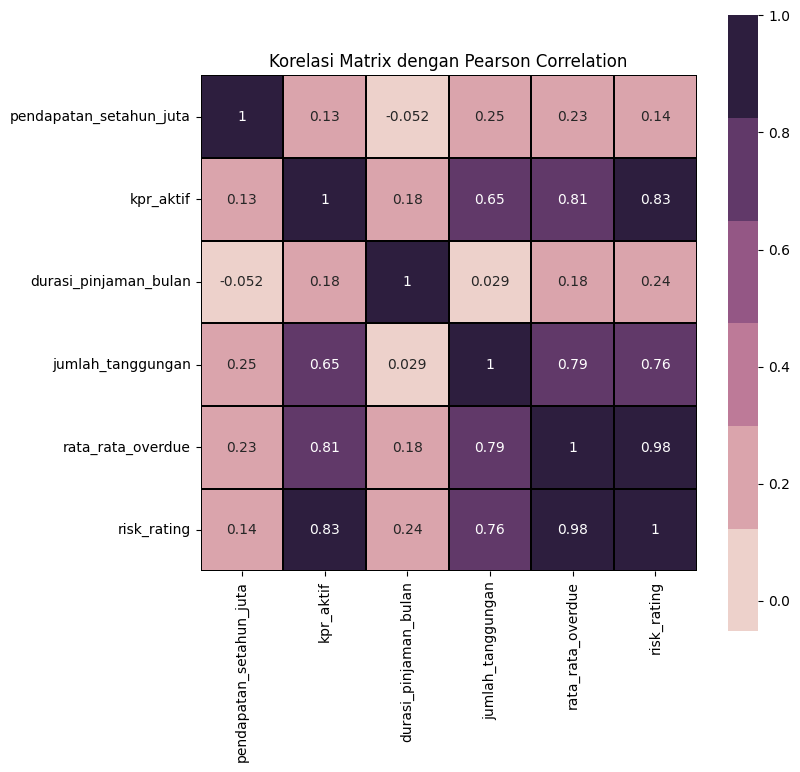

In [60]:
# melihat korelasi data
# f = gambar
# ax = axis
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Korelasi Matrix dengan Pearson Correlation')
sns.heatmap(dataset.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True, linecolor='black', annot=True, cmap=sns.cubehelix_palette())

diagram yang muncul adalah diagram heatmap. Diagram ini biasanya digunakan untuk mendapatkan hubungan antara dua variabel. semakin gelap warna diagram tersebut, maka semakin kuat hubungan antara variabel.
jika dilihat, hubungan antara rata-rata_overdue dan risk_rating adalah yang paling kuat, sebesar 0.98, hampir mendekati 1. Artinya, semakin tinggi rata rata keterlambatan seseorang dalam pembayaran maka semakin tinggi pula peringkat resikonya.

jika diperhatikan kembali pada gambar visualisasinya, korelasi  antara variabel pendapatan_setahun_juta dan durasi_pinjaman_bulan memiliki korelasi yang sangat rendah dengan risk_rating.

karena tujuan kita adalah untuk menemukan informasi yang berhubungan dengan tingkat_resiko. Maka kedua variabel tersebut kita anggap tidak memberikan informasi yang banyak.

Tujuan lainnya misalnya :
- untuk menyederhanakan model
- untuk meningkatkan pefoorma model
- untuk menghindari overfitting

In [61]:
# menghapus kolom pendapatan_setahun_juta dan durasi_pinjaman_bulan
dataset = dataset.drop(['pendapatan_setahun_juta', 'durasi_pinjaman_bulan'], axis=1)
dataset.head()

,kpr_aktif,jumlah_tanggungan,rata_rata_overdue,risk_rating
0,1,5,90,4
1,1,5,90,4
2,0,0,30,1
3,1,3,60,3
4,0,0,45,2


# Modeling dengan Naive Bayes

In [62]:
#input variabel x dengan drop kolom risk_rating kolom risk_rating digunakan sebagai label (y) dependend
x = dataset.drop('risk_rating', axis=1)
# input variabel y dengan  drop kolom label
y = dataset['risk_rating'].astype('category')

# bagi data untuk training dan testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


setelah melakukan pemisahan antara data train dan data testing, kita akan melakukan training terhadap data dengan menggunakan algoritma naive bayes

In [63]:
# menjalankan data training dengan naive bayes
model_nb = GaussianNB()
model_nb.fit(x_train, y_train)

#setelah datanya dibagi, lakukan prediksi pada data testing
y_pred = model_nb.predict(x_test)
print(f'terdapat {len(y_pred)} data yang telah di prediksi')
print(y_pred)

terdapat 180 data yang telah di prediksi
[2 1 3 2 4 4 1 3 3 5 1 2 5 2 3 3 1 3 3 4 2 3 3 1 5 3 3 3 3 3 2 3 5 3 1 4 4
 4 4 2 4 1 1 2 5 3 5 2 1 1 2 5 1 1 2 5 1 3 3 3 4 2 3 5 5 3 3 3 4 1 5 4 2 1
 1 4 3 3 3 5 1 2 3 2 4 3 1 3 2 1 2 3 2 2 3 1 2 5 5 1 1 1 3 1 5 4 3 5 2 2 3
 3 1 1 2 1 4 4 2 2 5 4 3 1 4 1 3 1 1 5 1 1 1 3 3 2 5 3 1 4 3 5 3 5 2 3 1 2
 2 3 3 3 3 4 5 3 3 4 3 1 2 1 1 1 2 1 3 1 4 2 1 1 4 2 2 1 1 1 3 3]


hasil yang diberikan merupakan nilai prediksi terhadap risk_rating dari perhitungan variabel_variabel input

**Pertanyaan selanjutnya, bagaimana menilai apakah model melakukannya dengan baik atau buruk?**

caranya adalah dengan menggunakan nilai akurasi.


In [67]:
penilaian_akurasi_nb = accuracy_score(y_test, y_pred)
print("hasil penilaian akurasi : ", peniaian_akurasi)
print(f"hasil penilaian akurasi terhadap model adalah : {penilaian_akurasi*100}%")

hasil penilaian akurasi :  1.0
hasil penilaian akurasi terhadap model adalah : 100.0%


nilai akurasi berkisar dari 0 hingga 1. Dimana 0 menjadi memiliki akurasi rendah dan 1 akurasi yang tinggi (sempurna).

Akurasi adalah metrik untuk mengevaluasi performa model klasifiikasi. Metrik ini mengukur sejauh mana, model memprediksi label kelas dengan benar.

Hasil output accuracy_score(y_test, y_pred) adalah 1.0. Ini berarti model Naive Bayes Anda telah memprediksi semua nilai risk_rating pada data testing (y_test) dengan tepat sesuai dengan nilai sebenarnya. Akurasi 1.0 menunjukkan performa yang sempurna pada data testing yang digunakan. **Namun, perlu diingat bahwa akurasi 1.0 pada data testing tidak selalu menjamin performa yang sama baiknya pada data baru yang belum pernah dilihat oleh model.**

# Evaluasi model dengan Confusion Matrix

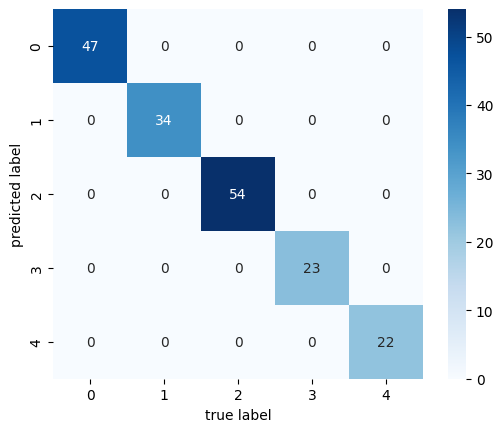

In [65]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm.T, square=True, annot=True, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

kita harus tau, kalau tujuan dari confusion matrix adalah mengetahui dimana model kita telah berhasil dan dimana model melakukan kesalahan

ada dua informasi penting dari gambar visualisasi dengan heatmap ini, yaitu pola yang ada pada garis diagonal dan pola yang ada diluar garis diagonal tersebut

1. pola garis diagonal
ini adalah pola dari jalur keberhasilan. Angka angka yang ada pada jalur ini menunjukkan hasil prediksi yang benar
misal => 47 merupakan jumlah dari data yang kelas aslinya adalah 0. Dan model berhasil menebak semua data tersebut dengan tepat. juga ada 34 data yang kelas aslinya adalah 1, model berhasil mennebaknya sebagai 1.

2. pola yang berada di luar garis diagonal
arena ini dinamakan sebagai area kesalahan. Dimana model salah memprdiksi. jika diperhatikan, fakta nya bahwa semua angka yang berada di luar jalur diagonal adalah bernilai 0 menunjukkan kalau model tidak pernah melakukan kesalahan terhadap data pengujian.

# Modeling dengan K-Knearest Neighbor

sebbelumnya, aku udah buat modeling dari data itu dengan algoritma Naive Bayes. sekarang, aku mau buat perbandingan, bukan hanya berpatok pada satu algoritma saja. Disini aku akan membandingkan dengan algoritma KNN.

In [66]:
# import library
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

y_pred = model_knn.predict(x_test)
y_pred

array([2, 1, 3, 2, 4, 4, 1, 3, 3, 5, 1, 2, 5, 2, 3, 3, 1, 3, 3, 4, 2, 3,
       3, 1, 5, 3, 3, 3, 3, 3, 2, 3, 5, 3, 1, 4, 4, 4, 4, 2, 4, 1, 1, 2,
       5, 3, 5, 2, 1, 1, 2, 5, 1, 1, 2, 5, 1, 3, 3, 3, 4, 2, 3, 5, 5, 3,
       3, 3, 4, 1, 5, 4, 2, 1, 1, 4, 3, 3, 3, 5, 1, 2, 3, 2, 4, 3, 1, 3,
       2, 1, 2, 3, 2, 2, 3, 1, 2, 5, 5, 1, 1, 1, 3, 1, 5, 4, 3, 5, 2, 2,
       3, 3, 1, 1, 2, 1, 4, 4, 2, 2, 5, 4, 3, 1, 4, 1, 3, 1, 1, 5, 1, 1,
       1, 3, 3, 2, 5, 3, 1, 4, 3, 5, 3, 5, 2, 3, 1, 2, 2, 3, 3, 3, 3, 4,
       5, 3, 3, 4, 3, 1, 2, 1, 1, 1, 2, 1, 3, 1, 4, 2, 1, 1, 4, 2, 2, 1,
       1, 1, 3, 3])

## Evaluasi model dengan akurasi dan confusion matrix

In [68]:
penilaian_akurasi_knn = accuracy_score(y_test, y_pred)
print("hasil penilaian akurasi : ", penilaian_akurasi_knn)
print(f"hasil penilaian akurasi terhadap model adalah : {penilaian_akurasi*100}%")

hasil penilaian akurasi :  1.0
hasil penilaian akurasi terhadap model adalah : 100.0%


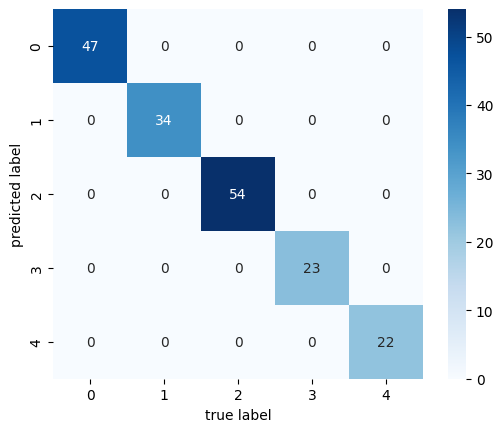

In [69]:
# evauasi dari visualisasi heatmap
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm.T, square=True, annot=True, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

jika dibandingkan hasil dari modeling sebelumnya, tampak hasil tingkat akurasi dan confusion matriknya sama.